<h1>Attribution Models</h1>

<br>

<h3><font color='grey'>Inspecting the data</font></h3>

<ul>
    <li><b><code>Libraries</code></b> - </li>
    <br>
    <li><b><code>pd.read_csv()</code></b> - </li>
</ul>

In [165]:
# libarires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# style
from ipynb.fs.full.Style_sheet import *
plt.style.use(style_use)
plt.rcParams.update(style_params)
color = palette_paired

# ignore slice warnings
import warnings
warnings.filterwarnings('ignore')

# read_csv
def read_csv(f):
    df = pd.read_csv(f, parse_dates=True)
    return df

# attribution data
f = r'Data\data_task.csv'
att = read_csv(f)

# show
print(att.dtypes)
att.head()

cookie                     object
date_time                  object
event                      object
conversion_value_pound    float64
channel                    object
dtype: object


,cookie,date_time,event,conversion_value_pound,channel
0,00000FkCnDfDDf0iC97iC703B,03/07/2018 13:02:11,impression,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,17/07/2018 19:15:07,impression,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,24/07/2018 15:51:46,impression,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,29/07/2018 07:44:51,impression,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,03/07/2018 09:44:57,impression,0.0,Paid Search


<hr>

<br>

<h3><font color='grey'>Cleaning Data</font></h3>

<ul>
    <li><b><code>date_time</code></b> - </li>
    <br>
    <li><b><code>fix_timestamp</code></b> - </li>
</ul>

In [166]:
# fix_timestamp
def fix_timestamp(df, col):
    ts = df[col].str[6:10] + '-' + df[col].str[3:5] + '-' + df[col].str[:2] + ' ' + df[col].str[11:19]
    df['date_time'] = ts.astype('datetime64[ns]')
    return df

fix_timestamp(att, 'date_time')

print(att.dtypes)
att.head()

cookie                            object
date_time                 datetime64[ns]
event                             object
conversion_value_pound           float64
channel                           object
dtype: object


,cookie,date_time,event,conversion_value_pound,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11,impression,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07,impression,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46,impression,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51,impression,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57,impression,0.0,Paid Search


<hr>

<br>

<h3><font color='grey'>Data Enrichment</font></h3>

<ul>
    <li><b><code>events_total</code></b> - </li>
    <br>
    <li><b><code>conv_user_ind & _value</code></b> - </li>
    <br>
    <li><b><code>rank_event</code></b> - </li>
    <br>
    <li><b><code>decay_time</code></b> - </li>
    <br>
    <li><b><code>30_day_ind</code></b> - </li>
</ul>

In [167]:
# total events
clk = pd.DataFrame(att.groupby('cookie')['cookie'].count())
clk.columns = ['event_total']
clk = clk.reset_index()
att = pd.merge(att, clk, on='cookie', how='left')


# flag converting users
col = ['cookie', 'conversion_value_pound','conv_user_ind']
cvr = att.query('event == "conversion"')
cvr[col[2]] = 1
cvr = cvr[col]
cvr.rename(columns={col[1]: 'conv_user_value'}, inplace=True)
att = pd.merge(att, cvr, on='cookie', how='left').fillna(0)


# rank clicks in journey
def rank_event(df, col, grp, asc):
    r = att.sort_values(col, ascending=asc)\
        .groupby(grp)\
        .cumcount() + 1
    return r

col = ['cookie', 'date_time']
grp = col[0]
att['seq_first_event'] = rank_event(att, col, grp, True)
att['seq_last_event'] = rank_event(att, col, grp, False)


# decay (days) from first/last click
def decay_time(df, c, p):
    
    if p == 1:
        m = att.groupby(c[0])[c[1]].min()
    else:
        m = att.groupby(c[0])[c[1]].max()  
        
    dcy = (df[c[1]] - att[c[0]].map(m)) * p
    dcy = dcy / np.timedelta64(1, 'D')
    return dcy

att['decay_first_event'] = decay_time(att, col, 1)
att['decay_last_event'] = decay_time(att, col, -1)


# flag events within 30 days of final event
att['day_30_ind'] = np.where(att['decay_last_event'] <= 30, 1, 0)
att = att.query('day_30_ind == 1')


# sample
att.query('cookie == "00EEFkC3oF309k7DFBkAkkEkC"')

,cookie,date_time,event,conversion_value_pound,channel,event_total,conv_user_value,conv_user_ind,seq_first_event,seq_last_event,decay_first_event,decay_last_event,day_30_ind
1234,00EEFkC3oF309k7DFBkAkkEkC,2018-07-08 16:17:05,impression,0.0,Facebook,6,5.5,1.0,1,6,0.000000,4.944525,1
1235,00EEFkC3oF309k7DFBkAkkEkC,2018-07-13 13:35:48,impression,0.0,Facebook,6,5.5,1.0,2,5,4.887998,0.056528,1
1236,00EEFkC3oF309k7DFBkAkkEkC,2018-07-13 13:36:20,impression,0.0,Instagram,6,5.5,1.0,3,4,4.888368,0.056157,1
1237,00EEFkC3oF309k7DFBkAkkEkC,2018-07-13 14:09:59,impression,0.0,Instagram,6,5.5,1.0,4,3,4.911736,0.032789,1
1238,00EEFkC3oF309k7DFBkAkkEkC,2018-07-13 14:10:13,impression,0.0,Facebook,6,5.5,1.0,5,2,4.911898,0.032627,1
1239,00EEFkC3oF309k7DFBkAkkEkC,2018-07-13 14:57:12,conversion,5.5,Facebook,6,5.5,1.0,6,1,4.944525,0.000000,1


<hr>

<br>

<h1><font color='black'>Buidling the Models</font></h1>

<br>

<h3><font color='grey'>Inspecting the data</font></h3>

<ul>
    <li><b><code>Libraries</code></b> - </li>
    <br>
    <li><b><code>pd.read_csv()</code></b> - </li>
</ul>

In [168]:
# viz_line
def viz_bar(ax, data, x, y, lb, title, xlb, ylb):
    sns.barplot(ax=ax, data=data, y=y, x=x, palette='Blues_d', label=lb)
    ax.set_title(title)
    ax.set_xlabel(xlb)
    ax.set_ylabel(ylb)
    ax.legend()
    return ax

x = 'seq_first_event'
xlb = 'Touch Points'
ylb = 'Attribution (£)'
sample = 'cookie == "00CEihEnfkihB77ooB79F9okF"'

<br>

<h3><font color='grey'>Single Touch Models</font></h3>

<ul>
    <li><b><code>first_touch</code></b> - </li>
    <br>
    <li><b><code>last_touch</code></b> - </li>
    <br>
    <li><b><code>last_touch_nd</code></b> - </li>
</ul>

In [169]:
# first touch
def att_touch_first(df, grp, ft, cvr, v):
    fst = df[[grp, ft, lt, cvr, e, v]]
    logic = (fst[cvr]==1) & (fst[ft]==1)
    fst['att_first_touch'] = np.where(logic, fst[v], 0)    
    fst = fst[[grp, ft, 'att_first_touch']]
    return fst

# last touch
def att_touch_last(df, grp, ft, lt, cvr, v):
    lst = df[[grp, ft, lt, cvr, v]]
    logic = (lst[cvr]==1) & (lst[lt]==1)
    lst['att_last_touch'] = np.where(logic, lst[v], 0)    
    lst = lst[[grp, ft, 'att_last_touch']]
    return lst

# last non direct touch
def att_touch_last_nd(df, grp, ft, lt, cvr, v, e):
    lstnd = df[[grp, ft, lt, cvr, v, e]]
    logic1 = (lstnd[cvr]==1) & (lstnd[lt]==1) & (lstnd[e]==1)
    logic2 = (lstnd[cvr]==1) & (lstnd[e]>1) & (lstnd[lt]==2)
    lstnd['att_last_touch_nd'] = np.where(logic1, lstnd[v], np.where(logic2, lstnd[v], 0))
    lstnd = lstnd[[grp, ft, 'att_last_touch_nd']]
    return lstnd

# variables
grp = 'cookie'
ft = 'seq_first_event'
lt = 'seq_last_event'
cvr = 'conv_user_ind'
e = 'event_total'
v = 'conv_user_value'

# unpack
fst = att_touch_first(att, grp, ft, cvr, v)
lst = att_touch_last(att, grp, ft, lt, cvr, v)
lstnd = att_touch_last_nd(att, grp, ft, lt, cvr, v, e)

# sample
sgl_sample = att.query(sample)
sgl_sample['att_first_touch'] = fst['att_first_touch']
sgl_sample['att_last_touch'] = lst['att_last_touch']
sgl_sample['att_last_touch_nd'] = lstnd['att_last_touch_nd']
sgl_sample

,cookie,date_time,event,conversion_value_pound,channel,event_total,conv_user_value,conv_user_ind,seq_first_event,seq_last_event,decay_first_event,decay_last_event,day_30_ind,att_first_touch,att_last_touch,att_last_touch_nd
942,00CEihEnfkihB77ooB79F9okF,2018-07-01 20:13:40,impression,0.0,Instagram,5,7.0,1.0,1,5,0.000000,11.772141,1,7.0,0.0,0.0
943,00CEihEnfkihB77ooB79F9okF,2018-07-02 17:59:19,impression,0.0,Facebook,5,7.0,1.0,2,4,0.906701,10.865440,1,0.0,0.0,0.0
944,00CEihEnfkihB77ooB79F9okF,2018-07-10 18:02:20,impression,0.0,Facebook,5,7.0,1.0,3,3,8.908796,2.863345,1,0.0,0.0,0.0
945,00CEihEnfkihB77ooB79F9okF,2018-07-11 17:21:54,impression,0.0,Instagram,5,7.0,1.0,4,2,9.880718,1.891424,1,0.0,0.0,7.0
946,00CEihEnfkihB77ooB79F9okF,2018-07-13 14:45:33,conversion,7.0,Facebook,5,7.0,1.0,5,1,11.772141,0.000000,1,0.0,7.0,0.0


<br>

<h3><font color='grey'>Linear</font></h3>

<ul>
    <li><b><code>linear</code></b> - </li>
</ul>

                        cookie  seq_first_event  att_linear
942  00CEihEnfkihB77ooB79F9okF                1         1.4
943  00CEihEnfkihB77ooB79F9okF                2         1.4
944  00CEihEnfkihB77ooB79F9okF                3         1.4
945  00CEihEnfkihB77ooB79F9okF                4         1.4
946  00CEihEnfkihB77ooB79F9okF                5         1.4


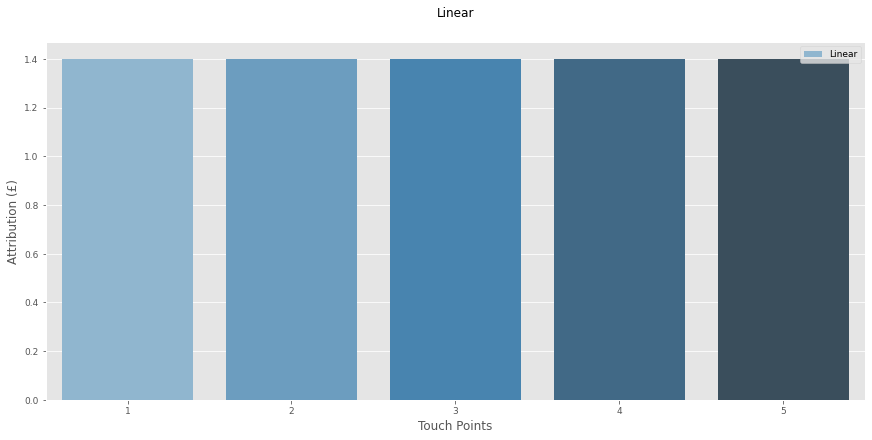

In [170]:
# linear
def att_linear(df, grp, fc, e, v):
    lnr = df[[grp, fc, e, v]]
    lnr['att_linear'] = lnr[v] / lnr[e]
    lnr = lnr[[grp, fc, 'att_linear']]
    return lnr

# variables
grp = 'cookie'
fc = 'seq_first_event'
e = 'event_total'
v = 'conv_user_value'

# unpack
lnr = att_linear(att, grp, fc, e, v)

# show
lnr_sample = lnr.query('cookie == "00CEihEnfkihB77ooB79F9okF"')
fig, ax_1 = plt.subplots(1, 1, figsize=(12,6), constrained_layout=True)
viz_bar(ax_1, lnr_sample, x, 'att_linear', 'Linear', 'Linear', xlb, ylb)
print(lnr_sample)
plt.show()

<br>

<h3><font color='grey'>Decay</font></h3>

<ul>
    <li><b><code>att_decay</code></b> - </li>
</ul>

In [171]:
# decay
def att_decay(df, grp, ft, dcyf, v):
    
    dcy = df[[grp, ft, dcyf, v]]
    dcy[dcyf] = 1 + dcy[dcyf]
    
    dcy_sum = pd.DataFrame(dcy.groupby(grp)[dcyf].sum())
    dcy_sum.columns = ['decay_scaler']
    dcy_sum = dcy_sum.reset_index()
    
    dcy = pd.merge(dcy, dcy_sum, on=grp, how='left')
    dcy['att_decay'] = ((dcy[dcyf])/dcy['decay_scaler']) * dcy[v]
    dcy = dcy[[grp, ft, 'att_decay']]
    
    return dcy

# variables
grp = 'cookie'
ft = 'seq_first_event'
dcyf = 'decay_first_event'
v = 'conv_user_value'

# unpack
dcy = att_decay(att, grp, ft, dcyf, v)

# sample
dcy_sample = dcy.query('cookie == "00CEihEnfkihB77ooB79F9okF"')
#fig, ax_1 = plt.subplots(1, 1, figsize=(12,6), constrained_layout=True)
#viz_bar(ax_1, dcy_sample, x, 'att_decay', 'Decay', 'Time Decay', xlb, ylb)
print(dcy_sample)
print('Sum: ' + str(dcy_sample['att_decay'].sum()))
#plt.show()

                        cookie  seq_first_event  att_decay
942  00CEihEnfkihB77ooB79F9okF                1   0.191947
943  00CEihEnfkihB77ooB79F9okF                2   0.365986
944  00CEihEnfkihB77ooB79F9okF                3   1.901966
945  00CEihEnfkihB77ooB79F9okF                4   2.088524
946  00CEihEnfkihB77ooB79F9okF                5   2.451577
Sum: 7.000000000000001


<br>

<h3><font color='grey'>Positional</font></h3>

<ul>
    <li><b><code>att_decay</code></b> - </li>
</ul>

                        cookie  seq_first_event   att_pos
942  00CEihEnfkihB77ooB79F9okF                1  0.640469
943  00CEihEnfkihB77ooB79F9okF                2  0.013117
944  00CEihEnfkihB77ooB79F9okF                3  0.201903
945  00CEihEnfkihB77ooB79F9okF                4  1.280948
946  00CEihEnfkihB77ooB79F9okF                5  4.863563


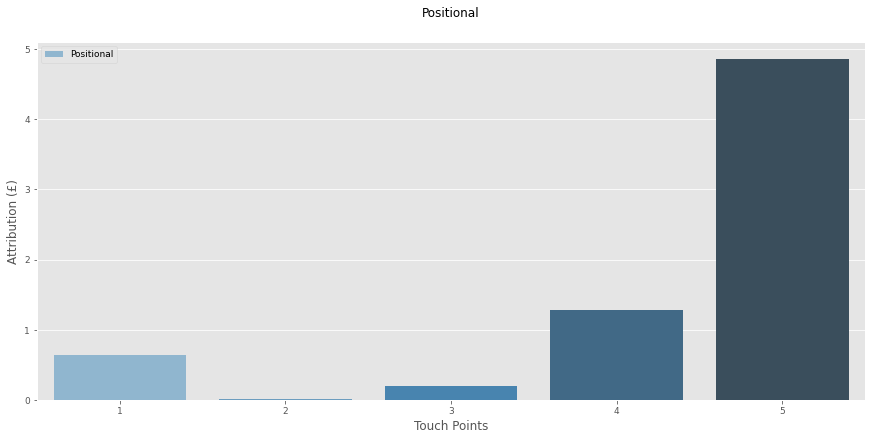

In [172]:
def att_pos(df, grp, ft, lt, e, v):
    pos = df[[grp, ft, lt, e, v]]
    
    pos['jrny_pc'] = pos[ft] / pos[e]
    pos['max'] = pos[[ft, lt]].values.max(1)
    
    pos['sc_up'] = 1 + (1 - 1/pos[ft])
    pos['sc_down'] = 1 + (1 - 1/pos[lt])
    
    # deceleration & acceleration
    pos['att_pos'] = (np.where(
                                pos['jrny_pc']<=0.5,
                               (pos[lt]-pos[ft])*(pos['sc_down']**3),
                               (pos['max']+1)*(pos['sc_up']**3)) ** 5
                     ) / 1E6
    
    pos_sum = pos.groupby(grp)['att_pos'].sum()
    pos_sum = pos_sum.reset_index()
    pos_sum.columns = ['cookie', 'pos_sc']
    
    pos = pd.merge(pos, pos_sum, on='cookie', how='left')
    pos['att_pos'] = (pos['att_pos']/pos['pos_sc']) * pos['conv_user_value']
    pos = pos[[grp, ft, 'att_pos']]
    
    return pos

# variables
grp = 'cookie'
ft = 'seq_first_event'
lt = 'seq_last_event'
e = 'event_total'
v = 'conv_user_value'

# unpack
pos = att_pos(att, grp, ft, lt, e, v)

# sample
pos_sample = pos.query('cookie == "00CEihEnfkihB77ooB79F9okF"')
fig, ax_1 = plt.subplots(1, 1, figsize=(12,6), constrained_layout=True)
viz_bar(ax_1, pos_sample, x, 'att_pos', 'Positional', 'Positional', xlb, ylb)
print(pos_sample)
plt.show()

<hr>

<br>

<h1><font color='black'>Bringing the Models Together</font></h1>

<br>

<h3><font color='grey'>Merging Tables</font></h3>

<ul>
    <li><b><code>merge</code></b> - </li>
    <br>
    <li><b><code>Validating the models</code></b> - </li>
</ul>

In [173]:
# keys
key = ['cookie', 'seq_first_event']

# merge
att = pd.merge(att, fst, on=key, how='left')
att = pd.merge(att, lst, on=key, how='left')
att = pd.merge(att, lstnd, on=key, how='left')
att = pd.merge(att, lnr, on=key, how='left')
att = pd.merge(att, dcy, on=key, how='left')
att = pd.merge(att, pos, on=key, how='left')

# sample
att.query(sample)

#att.groupby('channel')['att_decay'].sum()
#att.groupby('channel')['att_pos'].sum()

,cookie,date_time,event,conversion_value_pound,channel,event_total,conv_user_value,conv_user_ind,seq_first_event,seq_last_event,decay_first_event,decay_last_event,day_30_ind,att_first_touch,att_last_touch,att_last_touch_nd,att_linear,att_decay,att_pos
942,00CEihEnfkihB77ooB79F9okF,2018-07-01 20:13:40,impression,0.0,Instagram,5,7.0,1.0,1,5,0.000000,11.772141,1,7.0,0.0,0.0,1.4,0.191947,0.640469
943,00CEihEnfkihB77ooB79F9okF,2018-07-02 17:59:19,impression,0.0,Facebook,5,7.0,1.0,2,4,0.906701,10.865440,1,0.0,0.0,0.0,1.4,0.365986,0.013117
944,00CEihEnfkihB77ooB79F9okF,2018-07-10 18:02:20,impression,0.0,Facebook,5,7.0,1.0,3,3,8.908796,2.863345,1,0.0,0.0,0.0,1.4,1.901966,0.201903
945,00CEihEnfkihB77ooB79F9okF,2018-07-11 17:21:54,impression,0.0,Instagram,5,7.0,1.0,4,2,9.880718,1.891424,1,0.0,0.0,7.0,1.4,2.088524,1.280948
946,00CEihEnfkihB77ooB79F9okF,2018-07-13 14:45:33,conversion,7.0,Facebook,5,7.0,1.0,5,1,11.772141,0.000000,1,0.0,7.0,0.0,1.4,2.451577,4.863563


<hr>

<br>

<h1><font color='black'>Model Comparison</font></h1>

<br>

<h3><font color='grey'>Aggregation</font></h3>

<ul>
    <li><b><code>merge</code></b> - </li>
</ul>